In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import reduced_model as red
import glob
import itertools
import os
import arviz as az
import scipy.stats as stats
import reduced_mcmc as mcmc
import importlib
import yaml
from scipy.linalg import block_diag
from itertools import product

plt.rcParams['figure.facecolor'] = "white"

In [3]:
def simple_temperature(vals, min_temp, max_temp, year_length=365):
    a = ((max_temp - min_temp) / 2)
    temps = a*(1 - np.cos(2*np.pi*vals / year_length)) + min_temp
    return(temps)

## Question 1: What are the relative contributions of infection and demographic processes to seasonal Bd dynamics in leopard frogs?

We fit reduced IPMs to leopard frog populations in four locations: LA, TN, PA, and VT

Four each location we fit 12 models (described in the main text)

- Four hypotheses about the relative contributions of infection processes and demography
    - null_model : Equivalent to "Demography-dependent transmission"
    - trans_beta_temp : Equivalent to "Temperature-dependent Bd transmission"
    - a_temp : Equivalent to "Temperature-dependent Bd growth"
    - both_model : Equivalent to "Temperature-dependent Bd growth and transmission"
- Three different assumptions regarding host density
    - High density: K = 4
    - Medium density: K = 8
    - Low density: K = 10
    
So, 4 $\times$ 3 = 12 models

We then compared model fits using DIC

The naming nomenclature for the pickled files containing the model results is described with the following example

`VT_trans_beta_temp_LIPI_allsites_ext_beta_prior_K=10_omega=1.pkl`

- `VT`: The geographic location
- `trans_beta_temp`: The model identifier
- `LIPI`: The leopard frog species (LIPI: Rana pipiens, LISP: Rana sphenocephala)
- `allsites_ext_beta_prior`: Indicates that all sites are being used, an external zoospore pool is being included, and there is an informative prior on trans_beta.
- `K=10`: K = 10 is a low density assumption.
- `omega=1`: Because the external zoospore pool is being fit, omega=1 is a place holder.


In [23]:
# DOD, species pairs
dod_locations = [('PA', 'LIPI'), ('VT', 'LIPI'),
                 ('LA', 'LISP'), ('TN', 'LISP')]

model_type = ['null_model', 'trans_beta_temp', 'a_temp', 'both_model'] # Four different hypotheses
loss_type = ["", '_loss_load'] # Does loss of infection depend on load
beta_prior = ["", "beta_prior_"] # Is there an informative prior on trans_beta?
exclude_type = ["", "exclude_"] # Are LA data in early 2017 excluded? 
fit_external = ["", "ext_"] # Are we fitting an external zoospore pool?
model_combos = list(product(model_type, loss_type, beta_prior, exclude_type, fit_external))

# These give the different density assumptions: 4: Higher density, 8: Medium density, 10: Low density
Kvals = [4, 8, 10]
omega_vals = [(1, "")]

dic_vals = []

for K in Kvals:
    
    for omega, var_temp in omega_vals:

        for dod, spp_nm in dod_locations:

            spps = [spp for spp in 
                    yaml.safe_load(open("model_params/{0}_params/{0}_site_level_params.yml".format(dod), "r"))['spp'].keys()]

            for spp in [spp_nm]:
                for model_nm, loss, beta_prior, exclude, ext in model_combos:
                    
                    try:
                        fname = "../results/pickled_results/{0}_{3}_{1}_allsites_{9}{7}{8}{6}K={2}{4}_omega={5}.pkl".format(dod, spp, K, model_nm, loss, omega, var_temp, beta_prior, exclude, ext)
                        mcmc_res = pd.read_pickle(fname)

                        res = (str(omega) + "_" + var_temp, beta_prior, exclude, ext, K, dod, spp, model_nm + loss, mcmc_res['DIC_values'][0], *mcmc_res['diagnostics'], fname)
                        dic_vals.append(res)
                    except FileNotFoundError:
                        
                        # If file not found, pass
                        pass

dic_df = pd.DataFrame(dic_vals, columns=['omega', 'beta_prior', "exclude", "external", 'K', 'dod', 'spp', 'model_nm', 'DIC', 'Rhatless1.01', 'neffgreater400', "file"])

In [24]:
# Print DIC values
dic_df.sort_values(["dod", "model_nm"])

,omega,beta_prior,exclude,external,K,dod,spp,model_nm,DIC,Rhatless1.01,neffgreater400,file
10,1_,beta_prior_,,ext_,4,LA,LISP,a_temp_loss_load,1189.896647,True,True,../results/pickled_results/LA_a_temp_LISP_alls...
26,1_,beta_prior_,,ext_,8,LA,LISP,a_temp_loss_load,1184.613660,True,True,../results/pickled_results/LA_a_temp_LISP_alls...
42,1_,beta_prior_,,ext_,10,LA,LISP,a_temp_loss_load,1183.606114,True,True,../results/pickled_results/LA_a_temp_LISP_alls...
11,1_,beta_prior_,,ext_,4,LA,LISP,both_model_loss_load,1158.316446,False,True,../results/pickled_results/LA_both_model_LISP_...
27,1_,beta_prior_,,ext_,8,LA,LISP,both_model_loss_load,1155.408893,True,True,../results/pickled_results/LA_both_model_LISP_...
43,1_,beta_prior_,,ext_,10,LA,LISP,both_model_loss_load,1154.458312,True,True,../results/pickled_results/LA_both_model_LISP_...
8,1_,beta_prior_,,ext_,4,LA,LISP,null_model,1241.751887,True,True,../results/pickled_results/LA_null_model_LISP_...
24,1_,beta_prior_,,ext_,8,LA,LISP,null_model,1236.495383,True,True,../results/pickled_results/LA_null_model_LISP_...
40,1_,beta_prior_,,ext_,10,LA,LISP,null_model,1235.623233,True,True,../results/pickled_results/LA_null_model_LISP_...
9,1_,beta_prior_,,ext_,4,LA,LISP,trans_beta_temp,1217.411196,True,True,../results/pickled_results/LA_trans_beta_temp_...


**Note**: You will see a two models where the convergence tests of $\hat{R}$ have not passed (i.e., there are False values).  In all cases, direct examination of the MCMC chains show highly overlapping chains and only mild violations -- $\hat{R}$ always less than 1.03.

###  Make figure 2 in the manuscript

4
4


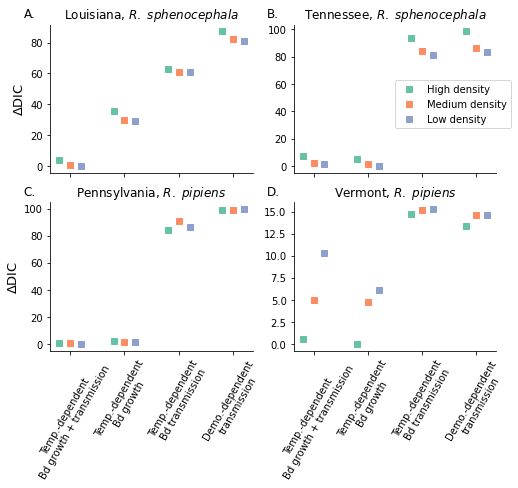

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=False, sharex=True)
axes = axes.ravel()

zpool_colors = ['#66c2a5','#fc8d62','#8da0cb']
perturb = np.linspace(-0.2, 0.2, num=3)

znames = ["High density", "Medium density", "Low density"] #['No external input', 'Constant external input', "Varying external input"]
pretty_model_names = ['Temp.-dependent\nBd growth + transmission',
                      'Temp.-dependent\nBd growth',
                      'Temp.-dependent\nBd transmission',
                      'Demo.-dependent\ntransmission']

state_lookup = {'LA': "Louisiana, $R.$ $sphenocephala$",
                'PA': "Pennsylvania, $R.$ $pipiens$",
                'TN': "Tennessee, $R.$ $sphenocephala$",
                'VT': "Vermont, $R.$ $pipiens$"}

letters = ['A.', 'B.', 'C.', 'D.']
# ['LA', 'TN', 'PA', 'VT']
for i, site in enumerate(['LA', 'TN', 'PA', 'VT']):
    ax = axes[i]
    tdat = dic_df.sort_values(by=['dod', 'DIC']).query("dod == '{0}' and K in [4, 8, 10]".format(site))
    
    model_names = ['both_model_loss_load','a_temp_loss_load','trans_beta_temp', 'null_model']
    
    tdat = tdat.query("model_nm in {0} and omega in ['1_'] and exclude == ''".format(model_names))
    

    Ks = np.sort(tdat.K.unique())
    zpools = np.sort(tdat.omega.unique())
    minDIC = tdat[tdat.beta_prior == 'beta_prior_'].DIC.min()
    
    for m, m_nm in enumerate(model_names):
        
        for z, K in enumerate(Ks):
            
            bp = 'beta_prior_'
            ext = "ext_"
            
            mdat = tdat.query("model_nm == '{0}' and beta_prior == '{2}' and K == '{1}' and external == '{3}'".format(m_nm, K, bp, ext))
            ax.plot([m + perturb[z]], mdat.DIC - minDIC, 's', color=zpool_colors[z])
    
    ax.set_title(state_lookup[site])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if ax.is_last_row():
        print(len(model_names))
        ax.set_xticks(np.arange(len(model_names)))
        ax.set_xticklabels(pretty_model_names)
        ax.tick_params(axis='x', rotation=60)
    
    if ax.is_first_col():
        ax.set_ylabel(r"$\Delta$DIC", size=13)
    
    handles = [plt.Line2D([1], [1], marker='s', linestyle="", color=col, label=nm) for col, nm in zip(zpool_colors, znames)]
    if i == 1:
        ax.legend(loc=(0.5, 0.3), handles=handles)
    
    ax.text(-0.1, 1.05, letters[i], size=12, ha='center', transform=ax.transAxes)

#fig.savefig("../results/plots/dic_plot.pdf", bbox_inches="tight")

## Simulate the best fit models from above

For exploration purposes, the code below allows you to explore the dynamics of the best fit models.

In [7]:
# Temperature ranges for states
dod_dict = {"LA": (4, 30),
            'TN': (4, 27),
            "PA": (4, 25),
            "VT": (4, 25)}

In [8]:

# Run a simulation of the best fit model
model_params = {'time_step': 7, 'mean_temp': 15}

dod = 'LA' # Choose your location
spps = ['LISP'] # Choose your species (LISP for LA and TN; LIPI for PA and VT)
Ks = np.repeat(4, len(spps)) # Choose your density (4, 8, or 10)
omega = 1 # Leave as is.  Omega is fit with the model.
loss_load = "loss_load_"  # Does loss of infection depend on load? True for "both_model" and "a_temp", False otherwise
model = "both_model"  # Specify your model: both_model, a_temp, trans_beta_temp, or null_model
beta_prior = "ext_beta_prior_" # Leave as is
external_zpool = True # If True, include external zoospore pool. Otherwise, only leopard frogs

spp_params = {}
for s, spp in enumerate(spps):
    
    mcmc_res = pd.read_pickle("../results/pickled_results/{0}_{4}_{1}_allsites_{6}K={2}_{5}omega={3}.pkl".format(dod, spp, Ks[s], omega, model, loss_load, beta_prior))
    chains = mcmc_res['chains']
    adapt = mcmc_res['adapt_param']
    
    base_params = mcmc_res['base_params'][spp].copy()
    ndarray = np.array([mcmc_res['mcmc_results'][i]['params'][spp][:, 5*adapt:].T for i in range(chains)])
    
    # Get the median of the estimated parameters
    med_params = np.percentile(ndarray, 50, axis=(0, 1))
    
    for i, p in enumerate(mcmc_res['parameters']):
        base_params[p] = med_params[i]
    
    hibernation_params = ['hibernation', 'hibernation_aquatic',
                          'hibernation_start', 'hibernation_end', 'sigma_full_temp']

    tparams = yaml.safe_load(open("model_params/{0}_params/spp_params_{1}.yml".format(dod, spp), "r"))

    for hp in hibernation_params:
        base_params[hp] = tparams['params'][hp]
    
    # Set your 
    
    if not external_zpool:
        # Since omega is fit on the log-scale, this sets external contribution to zero 
        base_params['omega'] = -1000000
    base_params['omega_temp'] = 0 # Make sure this is set to zero
    spp_params[spp] = base_params

# Initial conditions
init = {spp: np.array([0, 1.0, 1.0, 1.0]) for spp in spps}
init['Z']= np.array([1.0])
z_fxn = red.zsurv_fxn(model_params['time_step'])
start_date = pd.datetime(2016, 1, 1)

# Length of simulations
steps = 1001 

# Load in temperature data
year_length = 365
temp_data, base_dat, longterm = mcmc.get_temp_data(dod)
temp_fxn, temp_fxn_cv, temp_fxn_mm = mcmc.build_temperature_fxn(temp_data, base_dat, longterm, 1,
                                                                start_date=start_date)

# Uncomment to let temperature vary sinusoidally rather than based on the 
# observed empirical temperature data
# year_length = 364
# temp_fxn = lambda x: simple_temperature(x, dod_dict[dod][0], dod_dict[dod][1], year_length=year_length)

comm = red.Community(spp_params, z_fxn, init, model_params, area=1,
                     init_temp=temp_fxn(0), load_dependent=loss_load == "loss_load_",
                     year_length=year_length, init_from_equil=True)
res = comm.simulate(steps, temp_fxn=temp_fxn) 

('LA', 'LISP', 0.07366855953772598)


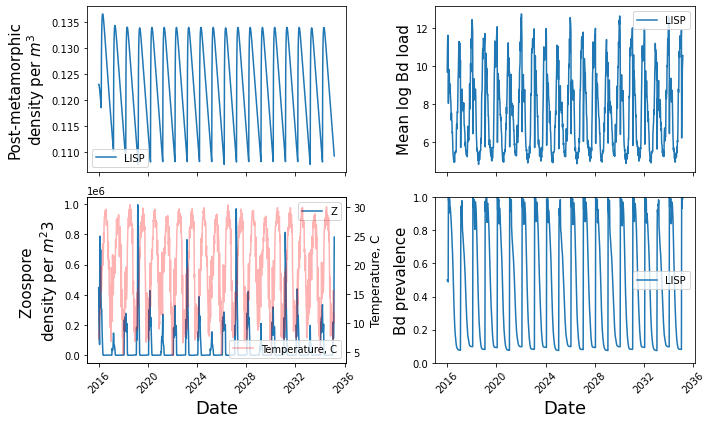

In [10]:
ps = 4
time = np.arange(steps)*model_params['time_step']
datetime = start_date + pd.to_timedelta(time, unit="D")
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

axes = axes.ravel()

for s, spp in enumerate(spps):
    
    tres = res[(4*s):(4*s + 4), :]
    
    axes[0].plot(datetime, tres[1, :] + tres[2, :], '-', ms=ps, label=spp)

    axes[1].plot(datetime, tres[3, :] / tres[2, :], '-', ms=ps, label=spp)
    #axes[3].plot(time, res[0, :], '-', ms=ps, label="T")
    tprev = tres[2, :] / (tres[1, :] + tres[2, :])
    axes[3].plot(datetime, tres[2, :] / (tres[1, :] + tres[2, :]), '-', ms=ps, label=spp)
    print((dod, spp, np.min(tprev)))
    
axes[1].set_ylabel("Mean log Bd load", size=15)
axes[2].set_ylabel("Zoospore \ndensity per $m^2$3", size=15)
axes[2].set_xlabel("Date", size=18)
axes[3].set_xlabel("Date", size=18)
axes[3].set_ylim(0, 1)
axes[3].set_ylabel("Bd prevalence", size=15)
axes[0].set_ylabel("Post-metamorphic\ndensity per $m^3$", size=15)
axes[2].plot(datetime, res[-1, :], '-', ms=ps, label="Z")
for ax in axes:
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

ax2 = axes[2].twinx()
ax2.plot(datetime, temp_fxn(time), '-', color="red", alpha=0.3, label="Temperature, C")
ax2.legend()
ax2.set_ylabel("Temperature, C", size=12)


plt.tight_layout()
plt.show()

### Make Figure 3 in the manuscript 

Plot of best fit model predictions compared to observed Bd prevalence and intensity

('LA', (382, 5))
('TN', (567, 5))
('PA', (411, 5))
('VT', (62, 5))


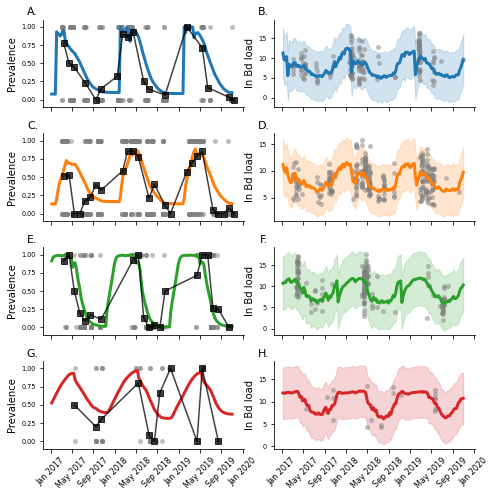

In [13]:
import importlib
import string
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
importlib.reload(red)
myFmt = mdates.DateFormatter('%b %Y')


# Run a simulation of the best fit model
model_params = {'time_step': 7, 'mean_temp': 15}
Ks = [10]  # Make predictions at low host density
omega = 1

# Best models from the above analysis
dod_spp_mods = [('LA', ['LISP'], 'both_model', "loss_load_", "ext_beta_prior_", 10), 
                ('TN', ['LISP'], 'a_temp', "loss_load_", "ext_beta_prior_", 10),
                ('PA', ['LIPI'], 'a_temp', "loss_load_", "ext_beta_prior_", 10),
                ('VT', ['LIPI'], 'a_temp', "loss_load_", "ext_beta_prior_", 10)]

fig, axes = plt.subplots(len(dod_spp_mods), 2, figsize=(7, 7), sharex=True)
axes = axes.ravel()
lw = 3

for f, (dod, spps, model, loss_load, beta_prior, K) in enumerate(dod_spp_mods):

    spp_params = {}
    for s, spp in enumerate(spps):

        mcmc_res = pd.read_pickle("../results/pickled_results/{0}_{4}_{1}_allsites_{6}K={2}_{5}omega={3}.pkl".format(dod, spp, K, omega, model, loss_load, beta_prior))
        chains = mcmc_res['chains']
        adapt = mcmc_res['adapt_param']

        base_params = mcmc_res['base_params'][spp].copy()
        ndarray = np.array([mcmc_res['mcmc_results'][i]['params'][spp][:, 5*adapt:].T for i in range(chains)])

        med_params = np.percentile(ndarray, 50, axis=(0, 1))

        for i, p in enumerate(mcmc_res['parameters']):
            base_params[p] = med_params[i]

        hibernation_params = ['hibernation', 'hibernation_aquatic',
                              'hibernation_start', 'hibernation_end', 'sigma_full_temp']

        tparams = yaml.safe_load(open("model_params/{0}_params/spp_params_{1}.yml".format(dod, spp), "r"))

        for hp in hibernation_params:
            base_params[hp] = tparams['params'][hp]

        base_params['omega_temp'] = 0

        spp_params[spp] = base_params

    init = {spp: np.array([0, 1.0, 1.0, 1.0]) for spp in spps}
    init['Z']= np.array([1.0])

    z_fxn = red.zsurv_fxn(model_params['time_step'])
    start_date = pd.datetime(2016, 1, 1)
    steps = 201

    temp_data, base_dat, longterm = mcmc.get_temp_data(dod)
    temp_fxn, temp_fxn_cv, temp_fxn_mm = mcmc.build_temperature_fxn(temp_data, base_dat, longterm, 1,
                                                                    start_date=start_date)

    comm = red.Community(spp_params, z_fxn, init, model_params, area=1.0,
                         init_temp=temp_fxn(0), load_dependent=loss_load == "loss_load_")#temp_fxn(0))
    res = comm.simulate(steps, temp_fxn=temp_fxn) 

    # Load the empirical data
    
    exclude = None
    fulldat = mcmc.load_and_format_data("../data/leopard_frog_data.csv",
                                           exclude=exclude)
    site_level_params = yaml.safe_load(open("model_params/{0}_params/{0}_site_level_params.yml".format(dod, "r")))
    dod_dat = fulldat[(fulldat.DOD_location == dod) &
                      (fulldat.Site_code.isin(site_level_params['sites'])) & 
                      (fulldat.Species_code == spps[0])]
    obs_dat = dod_dat[['Site_code', 'Species_code', 'Date', 'Bd_pos', 'Bd_load']]
    obs_dat = obs_dat.assign(Date = lambda x: pd.to_datetime(x.Date))

    ps = 4
    time = np.arange(steps)*model_params['time_step']
    datetime = start_date + pd.to_timedelta(time, unit="D")
    
    ax0 = axes[2*f]
    ax1 = axes[2*f + 1]
    ax0.xaxis.set_major_formatter(myFmt)
    ax1.xaxis.set_major_formatter(myFmt)
    
    norm = stats.norm(loc=0, scale=base_params['sigma_full'])
    upper = norm.ppf(.975)

    for s, spp in enumerate(spps):

        # Plot model predictions
        tres = res[(4*s):(4*s + 4), :]
        
        ind = datetime.year > 2016
        ax1.plot(datetime[ind], tres[3, :][ind] / tres[2, :][ind], '-', ms=ps, lw=lw, color=sns.color_palette()[f])
        ax1.fill_between(datetime[ind],  tres[3, :][ind] / tres[2, :][ind] - upper,  tres[3, :][ind] / tres[2, :][ind] + upper, alpha=0.2, zorder=-1, color=sns.color_palette()[f])
        ax0.plot(datetime[ind], tres[2, :][ind] / (tres[1, :][ind] + tres[2, :][ind]), '-', ms=ps, lw=lw, color=sns.color_palette()[f])

        sppdat = obs_dat[(obs_dat.Species_code == spp)]
        Bd_pos_ind = sppdat.Bd_pos == 1
        ax1.plot(sppdat[Bd_pos_ind].Date, np.log(sppdat[Bd_pos_ind].Bd_load), 'o', ms=5, mew=0, alpha=0.5, color="gray", zorder=-1)
        ax0.plot(sppdat.Date, sppdat.Bd_pos, 'o', ms=5, mew=0, alpha=0.5, color="gray", zorder=-1)
        print((dod, sppdat.shape))
        
        # Group prev
        prev = (sppdat[['Bd_pos', 'Date']].reset_index(drop=True)
                               .assign(month=lambda x: x.Date.dt.month,
                                       year=lambda x: x.Date.dt.year)
                               .groupby(['month', "year"]).agg({'Bd_pos': np.mean})
                               .reset_index()
                               .assign(date=lambda x: [pd.datetime(y, m, 15) for m, y in zip(x.month.values, x.year.values)])
                               .sort_values(by="date"))
        ax0.plot(prev.date, prev.Bd_pos, '-s', color="black", alpha=0.75)

    ax1.set_ylabel("ln Bd load", size=10)

    ax0.set_ylim(-0.1, 1.1)
    ax0.set_ylabel("Prevalence", size=10)

    if ax1.is_last_row():
        ax1.tick_params(axis='x', rotation=45, labelsize=8)
        #ax1.set_xlabel("Date", size=10)
    
    if ax0.is_last_row():
        ax0.tick_params(axis='x', rotation=45, labelsize=8)
        #ax0.set_xlabel("Date", size=10)

letters = string.ascii_uppercase
for i, ax in enumerate(axes):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=6.5)
    ax.text(-0.05, 1.05, letters[i] + ".", size=11, ha='center', transform=ax.transAxes)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
#plt.savefig("../results/plots/obs_pred_traj.pdf", bbox_inches="tight")

## Plot model coefficients for temperature effects on Bd growth

This is Figure S3 in the supplementary material

In [14]:
dod_locations = [('PA', 'LIPI'), ('VT', 'LIPI'), 
                 ('LA', 'LISP'), ('TN', 'LISP')]
model_combos = [("a_temp", "_loss_load") , ("both_model", "_loss_load")]

Ks = [4, 8, 10]
omega = 1
var_temp = ""
beta_prior = "ext_beta_prior_"

alldfs = []

for K in Ks:
    
 
    for dod, spp_nm in dod_locations:

        spps = [spp for spp in 
                yaml.safe_load(open("model_params/{0}_params/{0}_site_level_params.yml".format(dod), "r"))['spp'].keys()]


        for spp in [spp_nm]:

            for model_nm, loss in model_combos:

                mcmc_res = pd.read_pickle("../results/pickled_results/{0}_{3}_{1}_allsites_{7}{6}K={2}{4}_omega={5}.pkl".format(dod, spp, K, model_nm, loss, omega, var_temp, beta_prior))

                chains = mcmc_res['chains']
                adapt = mcmc_res['adapt_param']
                ndarray = np.array([mcmc_res['mcmc_results'][i]['params'][spp][:, 5*adapt:].T for i in range(chains)])
                ndarray_flat = np.concatenate([ndarray[i, :, :] for i in range(chains)], axis=0)
                pmeds = np.percentile(ndarray_flat, 50, axis=0)
                plower = np.percentile(ndarray_flat, 2.5, axis=0)
                pupper = np.percentile(ndarray_flat, 97.5, axis=0)

                tdf = pd.DataFrame(list(zip(plower, pmeds, pupper, mcmc_res['parameters'])), 
                                   columns=['lower','med', 'upper', 'param'])

                keyval = [("dod", dod), ("omega", str(omega) + "_" + var_temp), ("spp", spp), ("model", model_nm), ("loss", loss), ("K", K)]

                for tp, val in keyval:
                    tdf.loc[:, tp] = val

                alldfs.append(tdf)

alldfs = pd.concat(alldfs).reset_index(drop=True)

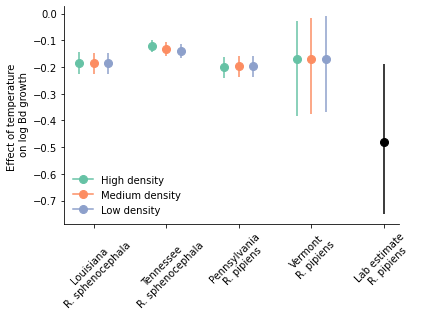

In [15]:
# Plot the a_temp coefficients
fig, ax = plt.subplots(1, 1)
dod_nms = ['LA', 'TN', 'PA', 'VT']

K_colors = ['#66c2a5','#fc8d62','#8da0cb']

for i, dod in enumerate(dod_nms):
    
    if dod == 'LA':
        tdf = alldfs.query("dod == '{0}' and model == 'both_model'".format(dod))
    else:
        tdf = alldfs.query("dod == '{0}' and model == 'a_temp'".format(dod))
    
    sep = np.linspace(-0.2, .2, num=3)
    for j, K in enumerate(np.sort(tdf.K.unique())):
        tK = tdf[(tdf.K == K) & (tdf.param == 'a_temp')]
    
        ax.errorbar([i + sep[j]], tK.med, yerr=[tK.med.values - tK.lower.values, 
                                                 tK.upper.values - tK.med.values], 
                     marker='o', markersize=8, color=K_colors[j])

# Plot lab results
med_lab = -0.48
lower_diff = med_lab - (-1*0.75)
upper_diff = -0.19 - med_lab
ax.errorbar([4], [med_lab], yerr=[[lower_diff], [upper_diff]], marker='o', color='black', markersize=8)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['Louisiana\nR. sphenocephala', 'Tennessee\nR. sphenocephala', 
                    'Pennsylvania\nR. pipiens', 'Vermont\nR. pipiens', 'Lab estimate\nR. pipiens'], rotation=45)
ax.set_ylabel("Effect of temperature \n on log Bd growth")

handles = [plt.Line2D([1], [1], marker='o', markersize=8, color=K_colors[i], label=tK) 
           for i, tK in enumerate(['High density', 'Medium density', 'Low density'])]
ax.legend(handles=handles, loc='lower left', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# fig.savefig("../results/plots/temperature_effects.pdf", bbox_inches='tight')

### For each location, calculate the instantaneous $R_0$ that gives the seasonal contribution of hosts to Bd persistence

In [21]:
## NOTE: the fxn simple_temperature is defined at the top of the notebook

# Hibernation parameters
hibernation_params = ['hibernation', 'hibernation_aquatic',
                      'hibernation_start', 'hibernation_end', 'sigma_full_temp']

# Model identifiers
steps = 208
omega = 1
year_length = 364
model_params = {'time_step': 7, 'mean_temp': 15}

# Set up model specification
start_date = pd.datetime(2016, 1, 1)
time = np.arange(steps)*model_params['time_step']
datetime = start_date + pd.to_timedelta(time, unit="D")

Ks = [4, 8, 10]

# Use the a_temp model for all models fit here.
dod_spp = [("LA", 'LISP', (4, 30), 'a_temp', 'loss_load_', 'ext_beta_prior_'),
           ('TN', 'LISP', (4, 27), 'a_temp', "loss_load_", "ext_beta_prior_"),
           ("PA", 'LIPI', (4, 25), 'a_temp', "loss_load_", "ext_beta_prior_")]

site_level_R0s_by_K = []

for K in Ks:
    
    site_level_R0s = {}
    all_long_arrays = {}
    rand_ints_by_model = {}

    for dod, spp_nm, temp_min_max, model, loss_load, beta_prior in dod_spp:

        print("Working on {0}".format(dod))

        spps = [spp_nm]
        init = {spps[0]: np.array([0, 1.0, 1.0, 1.0]) for spp in spps}
        init['Z']= np.array([1.0])
        z_fxn = red.zsurv_fxn(model_params['time_step'])
        temp_fxn_simple = lambda x: simple_temperature(x, temp_min_max[0], temp_min_max[1], year_length=year_length)
        temperature = temp_fxn_simple(time)

        # Get species-specific parameters
        spp_longarrays = {}
        for s, spp in enumerate(spps):

            mcmc_res = pd.read_pickle("../results/pickled_results/{0}_{3}_{1}_allsites_{6}K={2}_{4}omega={5}.pkl".format(dod, spp, K, model, loss_load, omega, beta_prior))
            chains = mcmc_res['chains']
            adapt = mcmc_res['adapt_param']

            # Combine chains
            base_params = mcmc_res['base_params'][spp].copy()
            base_params['omega'] = -1000000 # Set external contribution to 0

            # Add in hibernation parameters if they aren't present
            tparams = yaml.safe_load(open("model_params/{0}_params/spp_params_{1}.yml".format(dod, spp), "r"))
            for hp in hibernation_params:
                base_params[hp] = tparams['params'][hp]

            ndarray = np.array([mcmc_res['mcmc_results'][i]['params'][spp][:, 5*adapt:].T for i in range(chains)])
            long_ndarray = np.vstack(ndarray)
            spp_longarrays[spp] = (long_ndarray, mcmc_res['parameters'], base_params)


        all_long_arrays[dod] = spp_longarrays


        draws = 100 # Random parameter draws
        rand_ints = np.random.randint(0, spp_longarrays[spp][0].shape[0], size=draws)
        rand_ints_by_model[dod] = rand_ints
        #rand_ints = np.array([0])

        all_spp_R0s = []

        for j, r in enumerate(rand_ints):

            if (j % 10) == 0 :
                print("Sim. {0}".format(j))
            spp_R0s = []
            inpool_vals = {}
            # Build a community model with the random parameters
            spp_params = {}
            for s, spp in enumerate(spps):

                tlong, tparams, tbase = spp_longarrays[spp]
                for i, p in enumerate(tparams):
                    tbase[p] = tlong[r, i]

                spp_params[spp] = tbase

            # Build the community model and get R0s
            tcomm = red.Community(spp_params, z_fxn, init, model_params, area=1.0,
                                  init_temp=temp_fxn_simple(0), 
                                  load_dependent=loss_load == "loss_load_",
                                  year_length=year_length)

            if j == 0:
                tsim = tcomm.simulate(steps, temp_fxn=temp_fxn_simple)

            for s, spp in enumerate(spps):

                inpool = np.array([tcomm.in_pool(t)[s] for t in time / model_params['time_step']])
                inpool_vals[spp] = inpool

                # Time-varying abundance of adults
                N = tsim[(4*s):(4*s + 4), :][1:3, :].sum(axis=0)

                R0_vals = np.array([tcomm.spp_R0(spp, n, temp) for n, temp in zip(N, temperature)]) * inpool
                spp_R0s.append(R0_vals)

            all_spp_R0s.append(spp_R0s)

        site_level_R0s[dod] = all_spp_R0s
    
    site_level_R0s_by_K.append(site_level_R0s)

Working on LA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on TN
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on PA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on LA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on TN
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on PA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on LA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on TN
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90
Working on PA
Sim. 0
Sim. 10
Sim. 20
Sim. 30
Sim. 40
Sim. 50
Sim. 60
Sim. 70
Sim. 80
Sim. 90


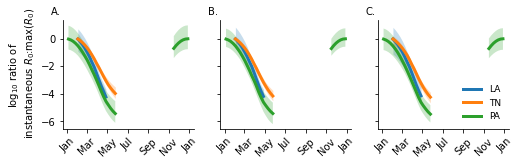

In [22]:
# Relative contribution
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')


fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharex=True, sharey=True)
axes = axes.ravel()

# Select a year
ind = (pd.Series(datetime < pd.datetime(2019, 1, 1)) & 
       pd.Series(datetime >= pd.datetime(2018, 1, 1))).values

titles = ['High density', 'Medium density', 'Low density']
letters = ['A.', 'B.', 'C.']


for tk, K in enumerate(Ks):

    spp_R0s = []
    ax = axes[tk]

    for i, (dod, spp_nm, tmm, tmodel, tloss_load, beta_prior) in enumerate(dod_spp):

        spps = [spp_nm]
        for j, spp in enumerate(spps):

            tR0s = np.array([spp_R0s[j] for spp_R0s in site_level_R0s_by_K[tk][dod]])

            lower = np.percentile(tR0s, 2.5, axis=0) 
            med = np.percentile(tR0s, 50, axis=0)
            upper = np.percentile(tR0s, 97.5, axis=0)

            if ((dod == 'TA') and (K in [4, 8, 10])):
                lt = ':'
            else:
                lt = "-"
            
            maxmed = np.max(med)
            maxlower = np.max(lower)
            maxupper = np.max(upper)
            ax.plot(datetime[ind], np.log10(med[ind] / maxmed), label=dod, 
                                            color=sns.color_palette()[i], linewidth=3, linestyle=lt)

            if not ((dod == 'TA') and (K in [4, 8, 10])):
                ax.fill_between(datetime[ind], np.log10(lower[ind] / maxmed), np.log10(upper[ind] / maxmed), 
                                color=sns.color_palette()[i], alpha=0.25, linewidth=0)

            spp_R0s.append(med)

    if ax.is_first_col():
        ax.set_ylabel("$\log_{10}$ ratio of\n instantaneous $R_0$:max($R_0$)")
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    ax.tick_params(axis="x", rotation=45)

    
    if ax.is_last_col():
        ax.legend(loc="lower right", frameon=False, prop={'size': 9})
        
    ax.xaxis.set_major_formatter(myFmt)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.05, 1.05, letters[tk], ha='center', transform=ax.transAxes)

#plt.savefig("../results/plots/instantaneous_R0_allK.pdf", bbox_inches="tight")

## Compute seasonal $R_0$

In [18]:
# Temperature ranges for states
dod_dict = {"LA": (4, 30),
            'TN': (4, 27),
            "PA": (4, 25),
            "VT": (4, 25)}

In [19]:

# Run a simulation of the best fit model
model_params = {'time_step': 7, 'mean_temp': 15}

# Default parameters for seasonal R0 calculation
omega = 1 # Leave as is.  Omega is fit with the model.
loss_load = "loss_load_"  # Does loss of infection depend on load? True for "both_model" and "a_temp", False otherwise
model = "a_temp"  # Specify your model: both_model, a_temp, trans_beta_temp, or null_model
beta_prior = "ext_beta_prior_" # Leave as is
external_zpool = False # If True, include external zoospore pool. Otherwise, only leopard frogs

# Loop through locations and densities
dod_locations = [('TN', 'LISP'), ('PA', 'LIPI')]
Kvals = [4, 8, 10]

seasonal_R0_values = []

for dod, spp_nm in dod_locations:
    spps = [spp_nm]
    
    for K in Kvals:
        
        Ks = np.repeat(K, len(spps))

        spp_params = {}
        for s, spp in enumerate(spps):
            
            # Load best fit parameters
            mcmc_res = pd.read_pickle("../results/pickled_results/{0}_{4}_{1}_allsites_{6}K={2}_{5}omega={3}.pkl".format(dod, spp, Ks[s], omega, model, loss_load, beta_prior))
            chains = mcmc_res['chains']
            adapt = mcmc_res['adapt_param']
            base_params = mcmc_res['base_params'][spp].copy()
            ndarray = np.array([mcmc_res['mcmc_results'][i]['params'][spp][:, 5*adapt:].T for i in range(chains)])

            # Get the median of the estimated parameters
            med_params = np.percentile(ndarray, 50, axis=(0, 1))
            
            # Assign parameters
            for i, p in enumerate(mcmc_res['parameters']):
                base_params[p] = med_params[i]

            hibernation_params = ['hibernation', 'hibernation_aquatic',
                                  'hibernation_start', 'hibernation_end', 'sigma_full_temp']

            tparams = yaml.safe_load(open("model_params/{0}_params/spp_params_{1}.yml".format(dod, spp), "r"))

            for hp in hibernation_params:
                base_params[hp] = tparams['params'][hp]


            if not external_zpool:
                # Since omega is fit on the log-scale, this sets external contribution to zero 
                base_params['omega'] = -1000000

            base_params['omega_temp'] = 0 # Make sure this is set to zero
            base_params['sI'] = 1 # Change to .97 to understand how sI affects seasonal R0
            spp_params[spp] = base_params

        # Initial conditions
        init = {spp: np.array([0, 1.0, 1.0, 1.0]) for spp in spps}
        init['Z']= np.array([1.0])
        z_fxn = red.zsurv_fxn(model_params['time_step'])
        start_date = pd.datetime(2016, 1, 1)

        # Length of simulations
        steps = 1001 
        year_length = 364
        temp_fxn = lambda x: simple_temperature(x, dod_dict[dod][0], dod_dict[dod][1], year_length=year_length)
        time = np.arange(steps)*model_params['time_step']
        
        # Simulate
        comm = red.Community(spp_params, z_fxn, init, model_params, area=1,
                             init_temp=temp_fxn(0), load_dependent=loss_load == "loss_load_",
                             year_length=year_length, init_from_equil=True)#temp_fxn(0))
        res = comm.simulate(steps, temp_fxn=temp_fxn) 


        ### Seasonal R0 calculation ###
        
        seasonal_lambdas = {}

        spps = np.array(list(spp_params.keys()))
        for s, spp in enumerate(spps):

            # Get time-varying abundance vector
            sind = np.where(np.array(spps) == spp)[0][0]
            N = res[(4*sind):(4*sind + 4)][1:3, :].sum(axis=0)
            means = res[(4*sind):(4*sind + 4)][3, :] / res[(4*sind):(4*sind + 4)][2, :]

            sind = 0
            start = np.where((time == (sind + year_length*4)))[0][0]
            end = np.where((time == (sind + year_length*5)))[0][0]
            tS = N[start:end]
            tmeans = means[start:end]

            tp = spp_params[spp].copy()

            min_temp = dod_dict[dod][0]
            max_temp = dod_dict[dod][1]
            tvals = time[start:end]

            seasonal_lambdas[spp] = red.get_seasonal_R0(tp, tvals, tS, tmeans, min_temp, max_temp, 
                                                    comm, model_params['time_step'],
                                                    year_length=year_length)
            
        seasonal_R0_values.append((dod, K, seasonal_lambdas[spp]['R0']))

In [20]:
# Print median seasonal R0 values when sI = 1
seasonal_R0_values

[('TN', 4, 1.891759399292247),
 ('TN', 8, 1.4787538428620397),
 ('TN', 10, 1.0570823865047885),
 ('PA', 4, 1.3527587713351077),
 ('PA', 8, 0.806274539638607),
 ('PA', 10, 0.35674863913968347)]